# evaluation

> This module evaluating RL agents on the electricity market environment.

In [ ]:
# | default_exp evaluation

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import itertools
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import rliable.metrics
import rliable.plot_utils
import seaborn as sns

from electricity_market.utils import EvaluationData, TrainingData

In [ ]:
# | export


def plot_all_metrics(
    agent_train_data: dict[str, TrainingData],
    agent_eval_data: dict[str, EvaluationData],
    n_seeds: int,
    n_episodes: int,
):
    sns.set_theme(style="whitegrid")

    def plot_learning_curve():
        for agent, data in agent_train_data.items():
            plt.plot(data.episodes, data.rewards, label=f"{agent} Learning Curve")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Learning Curves")
        plt.legend()
        plt.show()

    def plot_training_stability():
        for agent, data in agent_train_data.items():
            plt.plot(
                data.steps,
                np.cumsum(data.rewards) / (np.arange(len(data.steps)) + 1),
                label=f"{agent} Stability",
            )
        plt.xlabel("Steps")
        plt.ylabel("Cumulative Average Reward")
        plt.title("Training Stability")
        plt.legend()
        plt.show()

    def plot_sample_efficiency():
        for agent, data in agent_train_data.items():
            plt.plot(
                data.steps,
                np.cumsum(data.rewards) / (np.arange(len(data.steps)) + 1),
                label=f"{agent} Sample Efficiency",
            )
        plt.xlabel("Steps")
        plt.ylabel("Cumulative Average Reward")
        plt.title("Sample Efficiency Curve")
        plt.legend()
        plt.show()

    def plot_time_to_convergence():
        colors = sns.color_palette("tab10", n_colors=len(agent_train_data))

        for i, (agent, data) in enumerate(agent_train_data.items()):
            if len(np.shape(data.rewards)) == 1:
                converged_step = np.argmax(
                    np.diff(data.rewards) < 0.01
                )  # Example threshold for convergence
                plt.axvline(
                    x=data.steps[converged_step],
                    color=colors[i],
                    label=f"{agent} Time to Convergence",
                )
            else:
                print(f"Skipping {agent} due to invalid rewards data shape.")

        plt.xlabel("Steps")
        plt.ylabel("Reward")
        plt.title("Time-to-Convergence")
        plt.legend()
        plt.show()

    def plot_aggregate_metrics():
        metrics = {
            "IQM": [],
            "Median": [],
            "Mean": [],
        }
        agent_names = list(agent_eval_data.keys())

        for agent, data in agent_eval_data.items():
            rewards_matrix = np.array(data.rewards).reshape(n_seeds, n_episodes)

            metrics["IQM"].append(rliable.metrics.aggregate_iqm(rewards_matrix))
            metrics["Median"].append(rliable.metrics.aggregate_median(rewards_matrix))
            metrics["Mean"].append(rliable.metrics.aggregate_mean(rewards_matrix))

        # Create subplots for each metric
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for ax, (metric_name, values) in zip(axes, metrics.items()):
            sns.barplot(
                x=agent_names,
                y=values,
                ax=ax,
                hue=agent_names,
                palette="tab10",
                capsize=0.1,
                legend=False,
            )
            ax.set_title(f"{metric_name} Reward")
            ax.set_xlabel("Agent")
            ax.set_ylabel("Reward")
            ax.tick_params(axis="x", rotation=45)

        plt.suptitle("Aggregate Evaluation Metrics (rliable)")
        plt.tight_layout()
        plt.show()

    def plot_probability_of_improvement():
        # Create a list of all agents (keys from agent_eval_data)
        agents = list(agent_eval_data.keys())

        # Dictionaries to hold the probability estimates and interval estimates
        probability_estimates = {}
        probability_interval_estimates = {}

        # Compare each pair of agents using itertools.combinations
        for agent1, agent2 in itertools.combinations(agents, 2):
            # Get the rewards for each agent as lists
            rewards1 = agent_eval_data[agent1].rewards
            rewards2 = agent_eval_data[agent2].rewards

            rewards1_reshaped = np.array(rewards1).reshape(n_seeds, n_episodes)
            rewards2_reshaped = np.array(rewards2).reshape(n_seeds, n_episodes)

            # Calculate the probability of improvement between the two agents
            prob_improvement = rliable.metrics.probability_of_improvement(
                rewards1_reshaped, rewards2_reshaped
            )

            # Calculate the confidence intervals (e.g., bootstrap method, here assuming it is available)
            # If you have an existing method to calculate the intervals, apply it
            # For simplicity, we use placeholders here
            prob_interval = [0.0, 1.0]  # Replace with actual interval calculation

            # Store the probability and interval estimates
            pair = f"{agent1},{agent2}"
            probability_estimates[pair] = prob_improvement
            probability_interval_estimates[pair] = prob_interval

        # Plot the probability of improvement using the rliable function
        rliable.plot_utils.plot_probability_of_improvement(
            probability_estimates,
            probability_interval_estimates,
            ax=None,
            figsize=(8, 6),
            colors=None,
            color_palette="colorblind",
            alpha=0.75,
            xlabel="P(X > Y)",
            left_ylabel="Algorithm X",
            right_ylabel="Algorithm Y",
        )

        plt.title("Probability of Improvement between Algorithms")
        plt.show()

    def plot_performance_profiles():
        all_rewards = defaultdict(list)
        for agent, data in agent_eval_data.items():
            all_rewards[agent] = data.rewards
        for agent, rewards in all_rewards.items():
            sorted_rewards = np.sort(rewards)
            plt.plot(
                np.arange(len(sorted_rewards)),
                sorted_rewards,
                label=f"{agent} Performance Profile",
            )
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Performance Profiles")
        plt.legend()
        plt.show()

    def plot_catastrophic_forgetting():
        for agent, data in agent_eval_data.items():
            forgetting = np.abs(
                np.array(data.rewards) - np.mean(data.rewards)
            )  # Simplified measure
            plt.plot(data.episodes, forgetting, label=f"{agent} Forgetting")
        plt.xlabel("Episodes")
        plt.ylabel("Catastrophic Forgetting (Deviation from Mean Reward)")
        plt.title("Catastrophic Forgetting")
        plt.legend()
        plt.show()

    def plot_regret_analysis():
        for agent, data in agent_eval_data.items():
            regret = np.max(data.rewards) - np.array(data.rewards)
            plt.plot(data.episodes, regret, label=f"{agent} Regret")
        plt.xlabel("Episodes")
        plt.ylabel("Regret (Max - Current Reward)")
        plt.title("Regret Analysis")
        plt.legend()
        plt.show()

    def plot_robustness_to_perturbations():
        for agent, data in agent_eval_data.items():
            noise = np.random.normal(
                0, 0.1, size=len(data.rewards)
            )  # Adding noise as perturbation
            robustness = data.rewards + noise
            plt.plot(data.episodes, robustness, label=f"{agent} Robustness")
        plt.xlabel("Episodes")
        plt.ylabel("Reward (with Perturbations)")
        plt.title("Robustness to Perturbations")
        plt.legend()
        plt.show()

    def plot_pareto_frontier():
        all_rewards = defaultdict(list)
        for agent, data in agent_eval_data.items():
            all_rewards[agent] = data.rewards
        for agent, rewards in all_rewards.items():
            plt.scatter(
                np.arange(len(rewards)), rewards, label=f"{agent} Pareto Frontier"
            )
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Pareto Frontier for Multi-Objective Optimization")
        plt.legend()
        plt.show()

    # Call all the plot functions
    plot_learning_curve()
    plot_training_stability()
    plot_sample_efficiency()
    plot_time_to_convergence()
    plot_aggregate_metrics()
    plot_probability_of_improvement()
    plot_performance_profiles()
    plot_catastrophic_forgetting()
    plot_regret_analysis()
    plot_robustness_to_perturbations()
    plot_pareto_frontier()

In [ ]:
# | hide


with open("training_data_per_agent.pkl", "rb") as f:
    training_data_per_agent = pickle.load(f)

with open("evaluation_data_per_agent.pkl", "rb") as f:
    evaluation_data_per_agent = pickle.load(f)

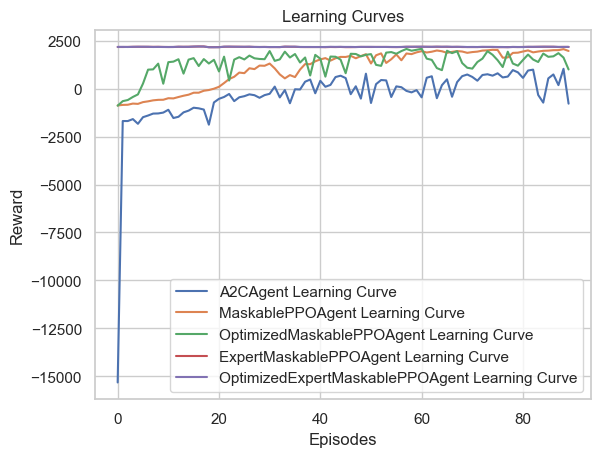

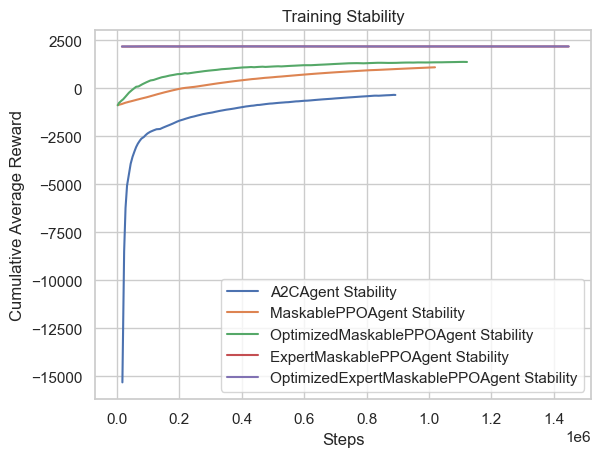

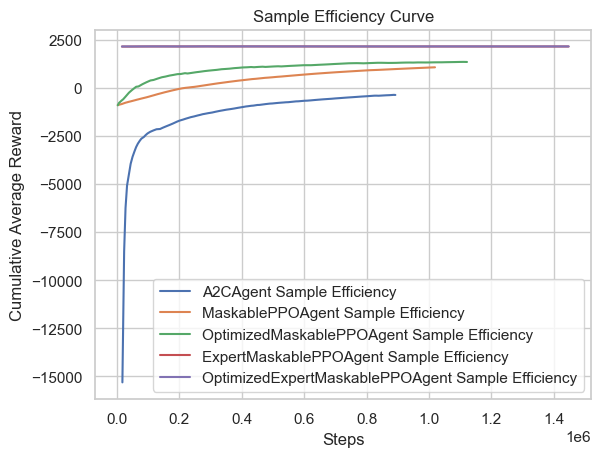

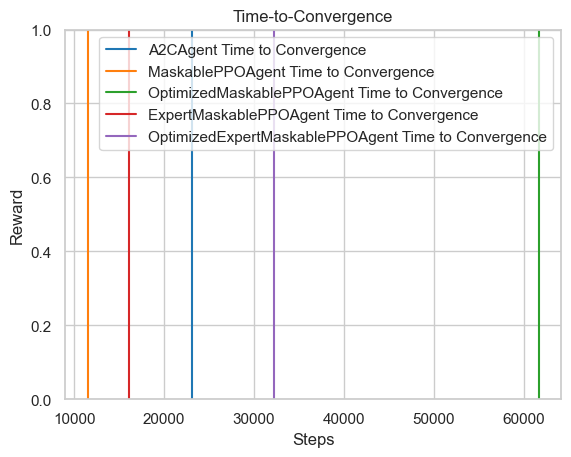

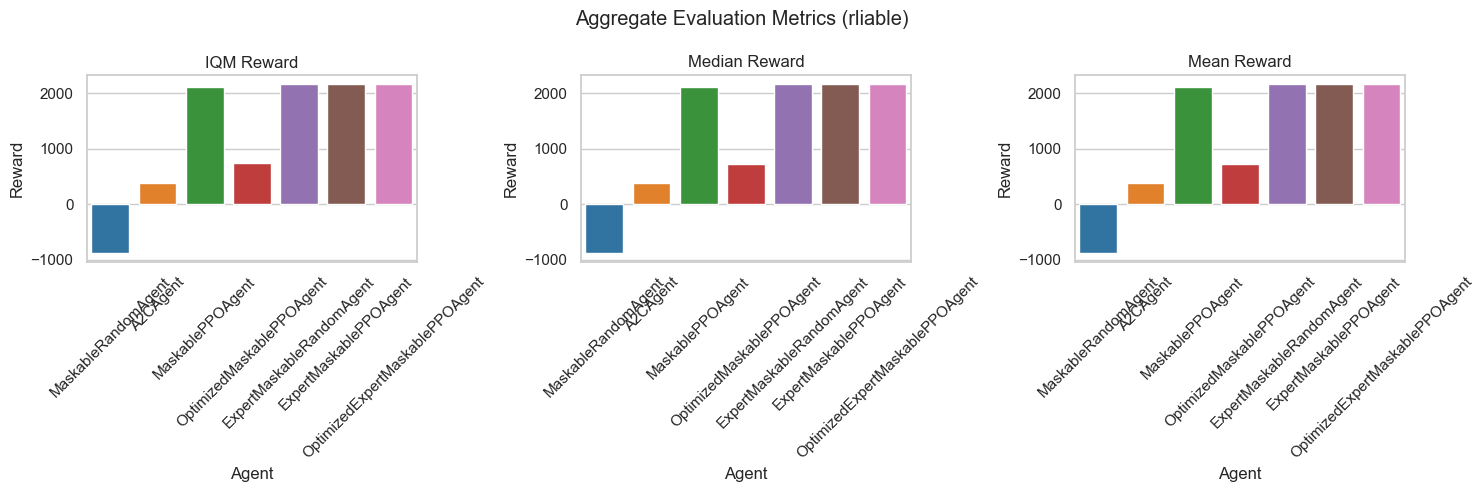

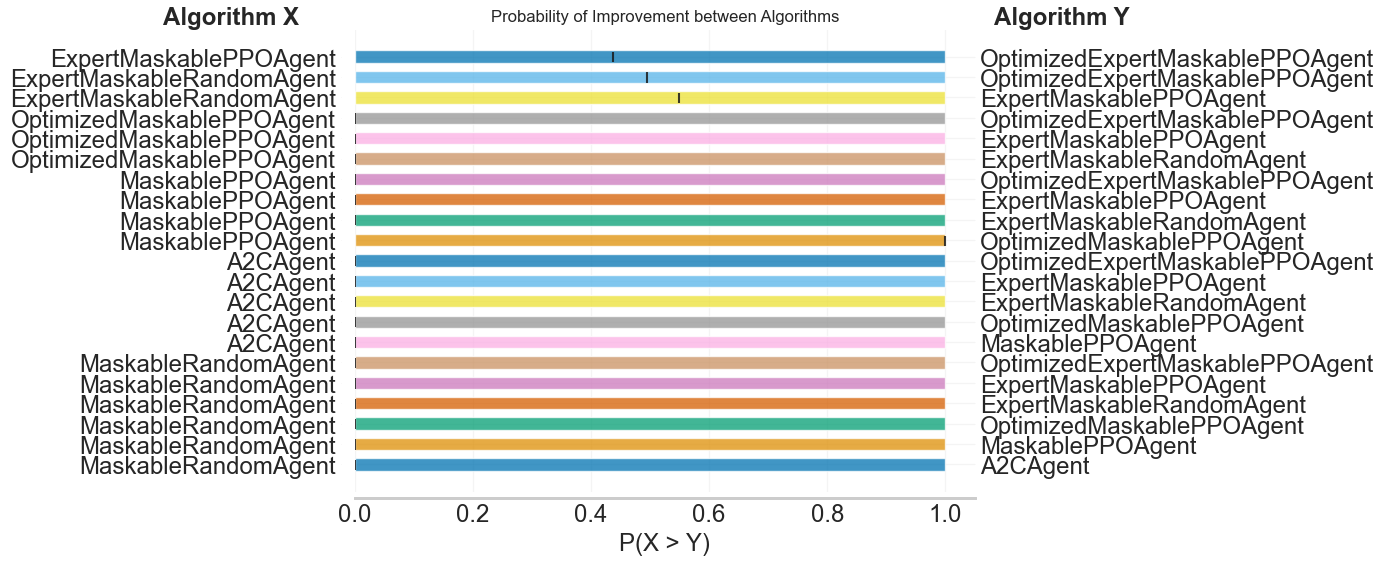

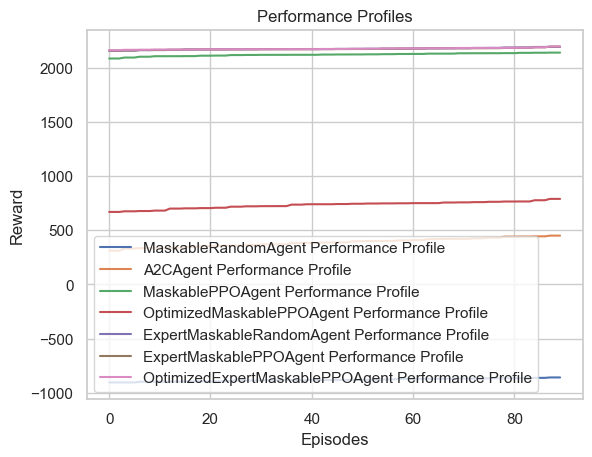

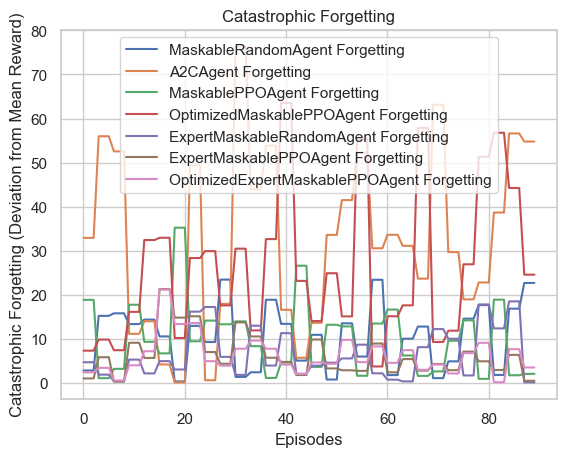

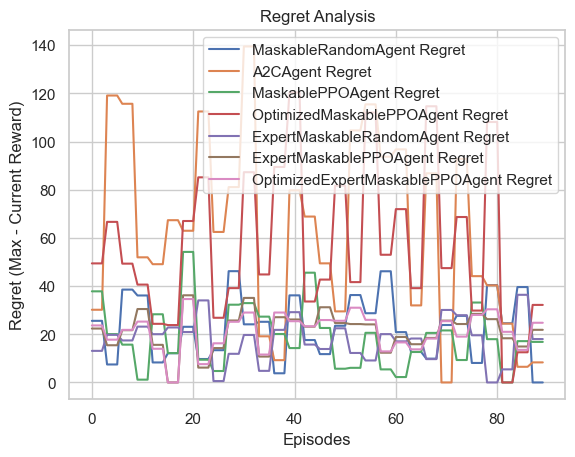

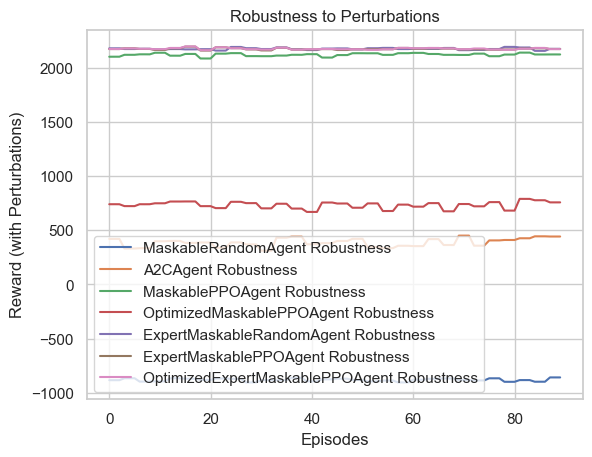

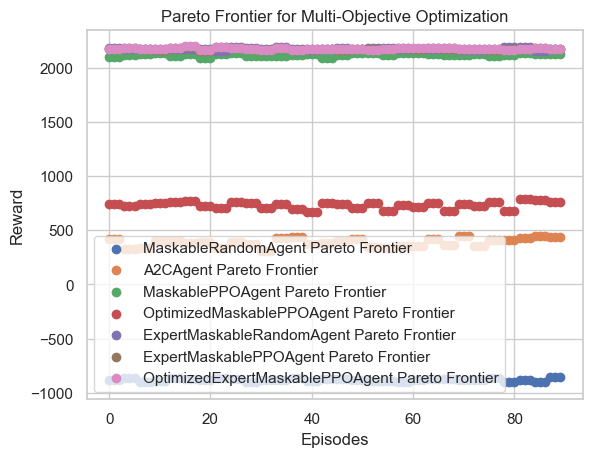

In [ ]:
# | hide
N_SEEDS = 30
N_EPISODES = 3
plot_all_metrics(
    training_data_per_agent, evaluation_data_per_agent, N_SEEDS, N_EPISODES
)

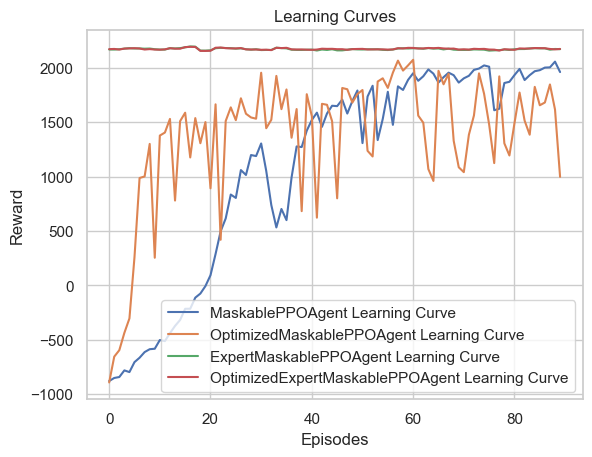

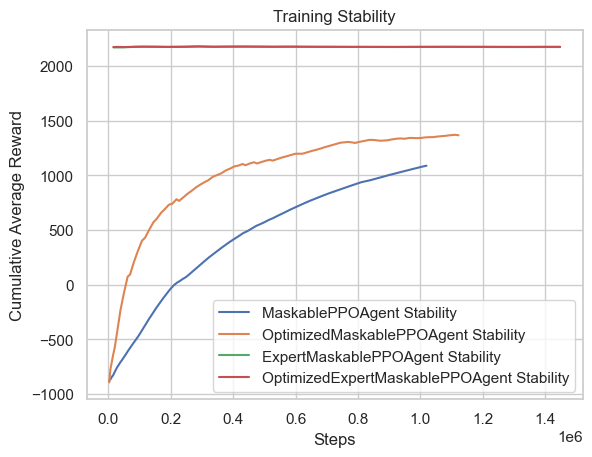

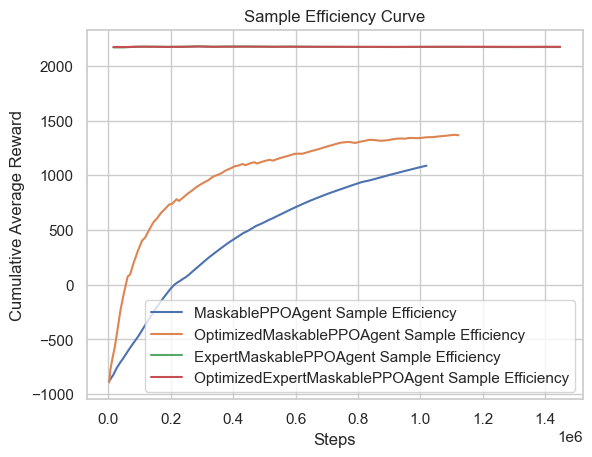

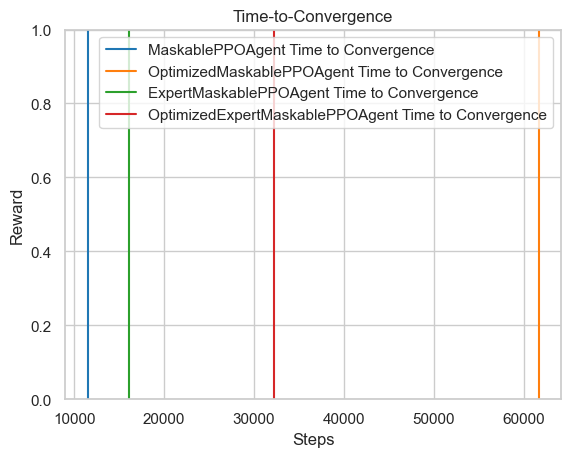

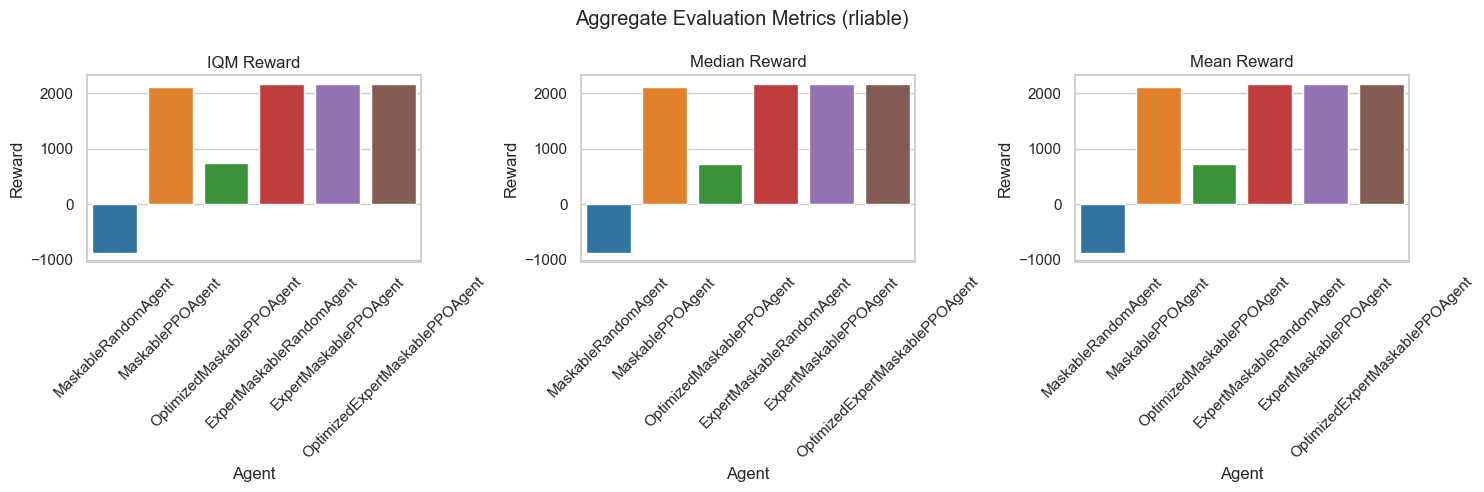

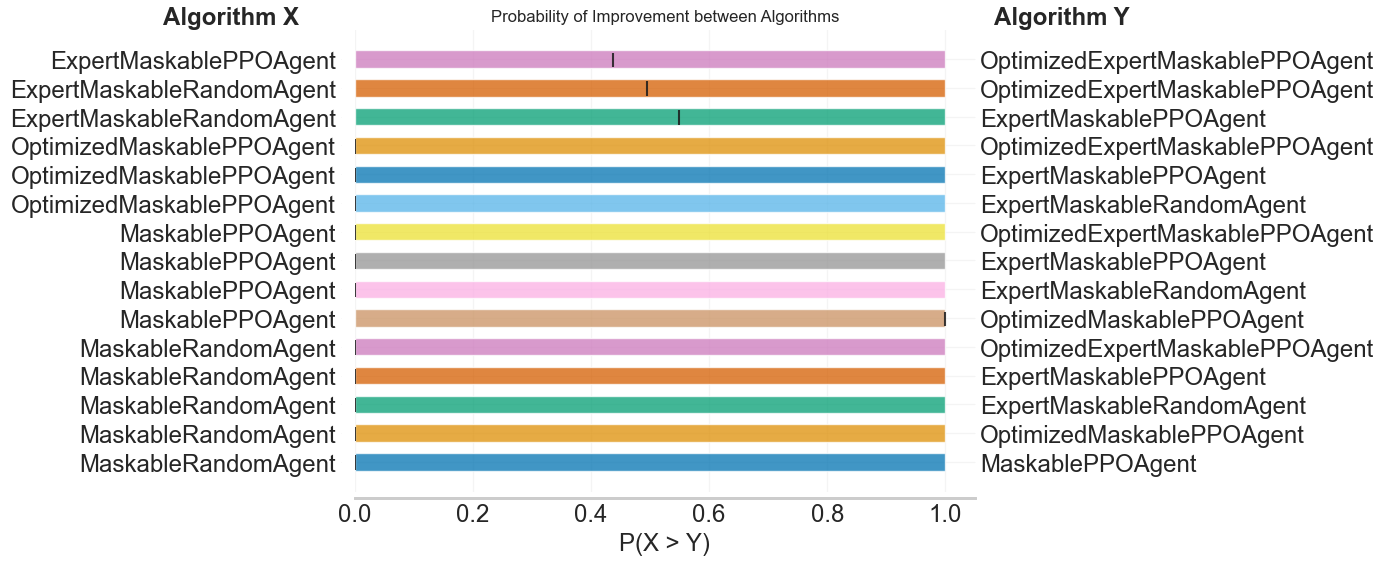

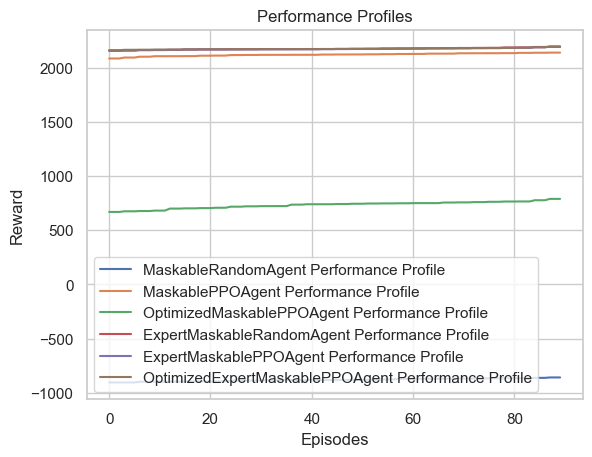

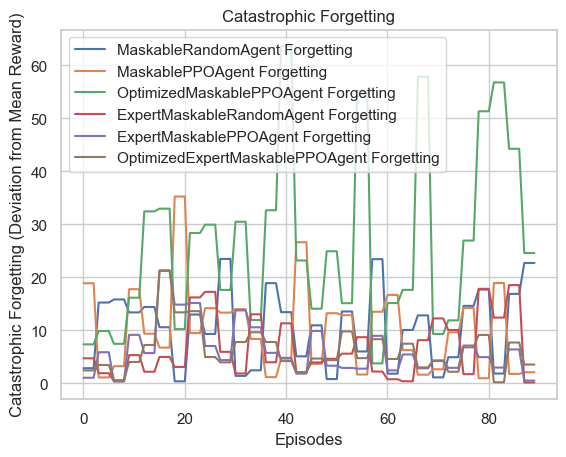

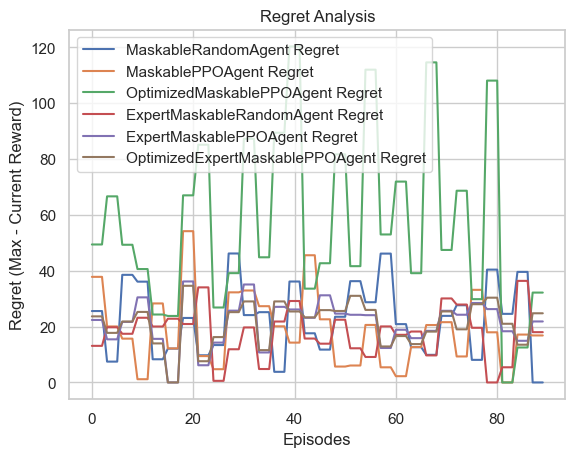

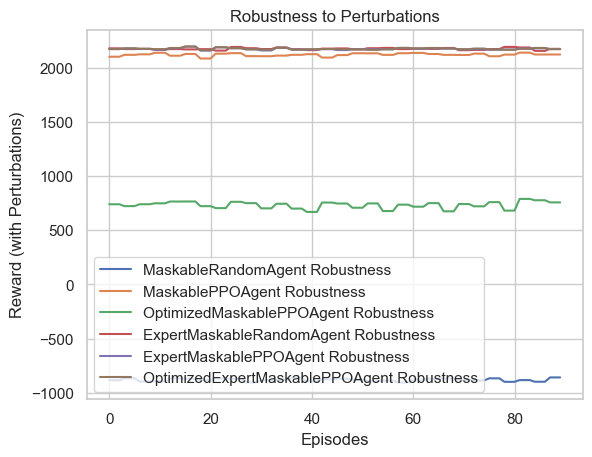

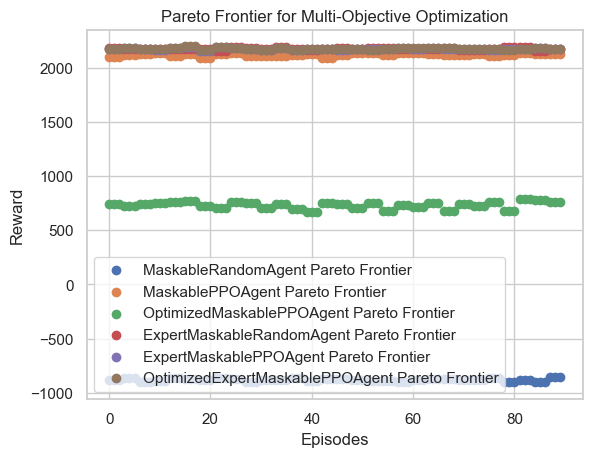

In [ ]:
# | hide

training_data_per_agent.pop("A2CAgent")
evaluation_data_per_agent.pop("A2CAgent")

plot_all_metrics(
    training_data_per_agent, evaluation_data_per_agent, N_SEEDS, N_EPISODES
)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()